In [246]:
%reload_ext autoreload
%autoreload 2

#note need to install transpile_benchy before running
#run 'pip install git+https://github.com/evmckinney9/transpile_benchy.git'

In [247]:
#circuits to test
from supermarq.benchmarks.ghz import GHZ
from supermarq.benchmarks.hamiltonian_simulation import HamiltonianSimulation
from supermarq.benchmarks.qaoa_vanilla_proxy import QAOAVanillaProxy
from supermarq.converters import cirq_to_qiskit


# # QAOA vanilla
def qaoa_vanilla_lambda(q):
    return cirq_to_qiskit(QAOAVanillaProxy(q).circuit())


from qiskit import QuantumCircuit

# weighted adder or ripple carry adder
from qiskit.circuit.library.arithmetic.adders.cdkm_ripple_carry_adder import (
    CDKMRippleCarryAdder,
)


# using trick of composing into an empty circuit so that it builds everything into a single quantumregister
def adder_lambda(q):
    return (
        QuantumCircuit(q)
        .compose(CDKMRippleCarryAdder(num_state_qubits=int((q - 1) / 2)), inplace=False)
        .decompose()
        .decompose()
        .decompose()
    )


# # GHZ
def ghz_lambda(q):
    return cirq_to_qiskit(GHZ(q).circuit())

In [248]:
from transpile_benchy.interface import QASMBench
from transpile_benchy.interface import QiskitFunctionInterface
from transpile_benchy.interface import SubmoduleInterface
from transpile_benchy.metrics import MetricInterface
from typing import Iterator, List
from qiskit import QuantumCircuit
#circuits to test
from qiskit.circuit.library import QuantumVolume
from qiskit.circuit.library.basis_change import QFT
from supermarq.benchmarks.ghz import GHZ
from supermarq.benchmarks.hamiltonian_simulation import HamiltonianSimulation
from supermarq.benchmarks.qaoa_vanilla_proxy import QAOAVanillaProxy
from supermarq.converters import cirq_to_qiskit

# class QVInterface(SubmoduleInterface):

#     def get_quantum_circuits(self) -> Iterator[QuantumCircuit]:
#         """Return an iterator over QuantumCircuits."""
#         for q in self.rangeQ:
#             yield QuantumVolume(num_qubits=q, depth=q)

#     def estimate_circuit_count(self) -> int:
#         return len(self.rangeQ)

# class QVBench(QVInterface):
#     def __init__(self, size: str):
#         """
#         size: 'small', 'medium', or 'large'
#         small is [4, 6, 8, 10, 12, 14, 16]
#         """
#         self.size = size
#         if size == 'small':
#             self.rangeQ = range(4, 17, 2) #specifies the range of qubits traversed
#         elif size == 'medium':
#             self.rangeQ = range(16, 33, 4)
#         elif size == 'large':
#             self.rangeQ = range(32, 65, 8) #specifies the range of qubits traversed
#         else:
#             self.rangeQ = range(4, 17, 2)
            
class CircuitsInterface(SubmoduleInterface):
    def get_quantum_circuits(self) -> Iterator[QuantumCircuit]:
        """Return an iterator over QuantumCircuits."""
        for q in self.rangeQ:
            if "QuantumVolume" in self.name:
                yield QuantumVolume(num_qubits=q, depth=q)
            elif "QFT" in self.name:
                yield QFT(q, name = self.name)
            elif "QAOA_Vanilla" in self.name:
                yield cirq_to_qiskit(QAOAVanillaProxy(q).circuit())
            elif "TIM_Hamiltonian" in self.name:
                yield cirq_to_qiskit(HamiltonianSimulation(q, 1 / q, 0.5).circuit())
            elif "Adder" in self.name:
                yield (
            QuantumCircuit(q)
            .compose(CDKMRippleCarryAdder(num_state_qubits=int((q - 1) / 2)), inplace=False)
            .decompose()
            .decompose()
            .decompose()
            )
            elif "GHZ" in self.name:
                yield cirq_to_qiskit(GHZ(q).circuit())
    def estimate_circuit_count(self) -> int:
        return len(self.rangeQ)

class CircuitBench(CircuitsInterface):
    def __init__(self, size, circuitName : str):
        """
        size: 'small', 'medium', or 'large'
        small is [4, 6, 8, 10, 12, 14, 16]
        """
        self.size = size
        self.name = circuitName
        if isinstance(size, int):
            self.rangeQ = [size]
        elif'small' in size:
            self.rangeQ = range(4, 17, 4) #specifies the range of qubits traversed
        elif 'medium' in size:
            self.rangeQ = range(16, 33, 4)
        elif 'large' in size:
            self.rangeQ = range(32, 65, 8) #specifies the range of qubits traversed
        else:
            self.rangeQ = range(4, 17, 2)



class TotalMetric(MetricInterface):
    """Calculate the total 2Q gate count of a circuit."""

    def __init__(self):
        """Initialize the metric."""
        self.name = "Total Gates"

    @staticmethod
    def calculate(circuit: QuantumCircuit) -> float:
        """Calculate the depth of a circuit."""
        # dumb way :)
        from qiskit.converters import circuit_to_dag
        dag = circuit_to_dag(circuit)
        return len(dag.two_qubit_ops())
        # # return circuit.depth(filter_function=lambda x: x[0].name not in exclude_gates)
        # total_cx_count = circuit.count_ops()["cx"]
        # critcal_path_cx_count = circuit.depth(filter_function=lambda x : len(x.qargs) != 2)

# qasm_bench = QASMBench(size="large")

# qv_bench = QVBench(size = "large")

qv_bench = CircuitBench(size=16, circuitName="QuantumVolume")
qft_bench = CircuitBench(size=16, circuitName="QFT")
qaoa_vanilla_bench  = CircuitBench(size=16, circuitName="QAOA_Vanilla")
tim_ham_bench = CircuitBench(size=16, circuitName="TIM_Hamiltonian")
adder_bench = CircuitBench(size=16, circuitName="Adder")
GHZ_bench = CircuitBench(size=16, circuitName="GHZ")

num_qubits = [16]
qv_bench = QiskitFunctionInterface(function_type = QuantumVolume, num_qubits=num_qubits)
qft_bench = QiskitFunctionInterface(function_type = QFT, num_qubits=num_qubits)
qaoa_vanilla_bench  = QiskitFunctionInterface(function_type = cirq_to_qiskit(QAOAVanillaProxy.circuit()), num_qubits=num_qubits)
tim_ham_bench = QiskitFunctionInterface(function_type = cirq_to_qiskit(HamiltonianSimulation.circuit()), num_qubits=num_qubits)
adder_bench = QiskitFunctionInterface(function_type = cirq_to_qiskit(QuantumCircuit(q)
            .compose(CDKMRippleCarryAdder()
            .decompose()
            .decompose()
            .decompose()), num_qubits=num_qubits)
GHZ_bench = QiskitFunctionInterface(function_type = cirq_to_qiskit(GHZ(q).circuit()), num_qubits=num_qubits)



from transpile_benchy.metrics import DepthMetric

depth_metric = DepthMetric()
total_metric = TotalMetric()

from qiskit.transpiler import CouplingMap

coupling_map = CouplingMap.from_grid(4, 5)

In [249]:
from transpile_benchy.runner import CustomPassManager
from qiskit.transpiler.passes import (
    DenseLayout,
    LookaheadSwap,
    TrivialLayout,
    BasicSwap,
    SabreLayout,
    SabreSwap,
)
from qiskit.transpiler.passes import (
    ApplyLayout,
    SetLayout,
    FullAncillaAllocation,
    EnlargeWithAncilla,
)


class Trivial_Basic(CustomPassManager):
    def main_process(self):
        """Process the circuit."""
        self.pm.append(
            [
                TrivialLayout(self.coupling),
                FullAncillaAllocation(self.coupling),
                EnlargeWithAncilla(),
                ApplyLayout(),
                BasicSwap(self.coupling),
            ]
        )


# class Dense_Lookahead(CustomPassManager):
#     def main_process(self, circuit):
#         """Process the circuit."""
#         self.main_pm.append(
#             [
#                 DenseLayout(coupling_map),
#                 FullAncillaAllocation(coupling_map),
#                 EnlargeWithAncilla(),
#                 ApplyLayout(),
#                 LookaheadSwap(coupling_map),
#             ]
#         )
#         return self.main_pm.run(circuit)


class SABRE(CustomPassManager):
    def main_process(self):
        """Process the circuit."""
        self.pm.append(
            [
                SabreLayout(self.coupling),
                # FullAncillaAllocation(coupling_map),
                # EnlargeWithAncilla(),
                # ApplyLayout(),
                SabreSwap(self.coupling),
            ]
        )



In [250]:
from qiskit import transpile
from abc import abstractmethod
from transpile_benchy.runner import AbstractRunner

class QiskitTranspileRunner(AbstractRunner):
    """used to noop the pre-, main-, post- passes"""
    def pre_process(self):
        pass
    
    def main_process(self):
        pass
    def post_process(self):
        pass

    @abstractmethod
    def run(self):
        """Abstract method for overloaded run method."""
        pass


class corral(QiskitTranspileRunner):
    def __init__(self, coupling_map, name:str=None):
        super().__init__(name=name)
        self.coupling_map = coupling_map
    def run(self, qc):
        return transpile(qc, coupling_map=self.coupling_map, optimization_level=3, basis_gates=["cx", "u"])

In [251]:
def snail_to_connectivity(snail_edge_list):
    # Convert snail edge list where nodes are snails and edges are qubits
    # To connectivity edge list where nodes are qubits and edges are coupling
    edge_list = []

    # qubits are coupled to a snail edge if they are both adjacent to a snail node
    for qubit, snail_edge in enumerate(snail_edge_list):
        for temp_qubit, temp_snail_edge in enumerate(snail_edge_list):
            if qubit != temp_qubit and (
                snail_edge[0] in temp_snail_edge or snail_edge[1] in temp_snail_edge
            ):
                edge_list.append((qubit, temp_qubit))
    return edge_list

# define corral
def corral_skip( num_snails=32, num_levels=2, level_1_skip=1, level_2_skip=1):
    """Returns edge list of a corral of size specified snails are nodes,
    edges are qubits."""

    snail_edge_list = []
    for snail0, snail1 in zip(range(num_snails), range(1, num_snails + 1)):
        for i in range(1, num_levels + 1):
            if i == 1:
                snail_edge_list.append(
                    ((snail0 + level_1_skip) % num_snails, snail0)
                )
            elif i == 2:
                snail_edge_list.append(
                    (snail0, (snail0 + level_2_skip) % num_snails)
                )
    return snail_edge_list

from qiskit.transpiler.coupling import CouplingMap
import retworkx as rx
import random
import logging
import h5py

from src.clonk.backend_utils.mock_backends.Corral_backend_v1 import FakeCorral
import numpy as np


def pretty_print(edge_list, simple=True):
    if simple: #simple only shows one connection if reverse node connection is there too
        temp = list(edge_list)
        temp2 = []
        for i, j in temp:
            if not (j, i) in temp2:
                temp2.append((i, j))
        edge_list = temp2

    x = CouplingMap(edge_list)

    # black magic errors when I modify the draw function directly in the CouplingMap file so Im just copying the code here to make it work
    import pydot
    from PIL import Image
    import io

    formatter2 = lambda edge: dict(dir="none", color="blue")


    pgraph = rx.PyGraph()

    graph_edges = x.get_edges()
    new_edges = []
    for e in graph_edges:
        e = list(e)
        e.append(1)
        new_edges.append(tuple(e))
    pgraph.add_nodes_from(list(range(64))) #update so not specific to 64 qubit corrals
    pgraph.add_edges_from(new_edges)
    #update edge colors?
    graph_colors = rx.graph_greedy_color(pgraph)

    # for node in graph_colors:
    #     print(node)
    #     x.graph[node] = graph_colors[node] # z

    
    dot_str = x.graph.to_dot(edge_attr=formatter2, graph_attr={"size": "0", "color":"blue"})

    dot = pydot.graph_from_dot_data(dot_str)[0]
    png = dot.create_png(prog="sfdp")
    pdf = dot.create_pdf(prog="sfdp")
    png = dot.create_png(prog="neato")
    return Image.open(io.BytesIO(png))

In [252]:
from qiskit.transpiler.coupling import CouplingMap

input_corrals = {}
N = 32 #N is number of snails 2*N is number of qubits
first = 1
for i in range(0, 32, 4):
    name = f'corral_N_{N}_({first}_{i})'
    input_corrals[i] =  CouplingMap(snail_to_connectivity(corral_skip(num_snails = N, level_1_skip=first, level_2_skip=i)))


# display(pretty_print(snail_to_connectivity(corral_skip(num_snails = N, level_1_skip=first, level_2_skip=1))))
# display(pretty_print(snail_to_connectivity(corral_skip(num_snails = N, level_1_skip=first, level_2_skip=12))))
# display(pretty_print(snail_to_connectivity(corral_skip(num_snails = N, level_1_skip=first, level_2_skip=28))))
# display(pretty_print(snail_to_connectivity(corral_skip(num_snails = N, level_1_skip=first, level_2_skip=32))))
# display(pretty_print(snail_to_connectivity(corral_skip(num_snails = N, level_1_skip=first, level_2_skip=48))))

# display(pretty_print(corral_skip(num_snails = N, level_1_skip=first, level_2_skip=1) , simple =  False))
# display(pretty_print(corral_skip(num_snails = N, level_1_skip=first, level_2_skip=12), simple =  False))
# display(pretty_print(corral_skip(num_snails = N, level_1_skip=first, level_2_skip=28), simple =  False))
# display(pretty_print(corral_skip(num_snails = N, level_1_skip=first, level_2_skip=32), simple =  False))
# display(pretty_print(corral_skip(num_snails = N, level_1_skip=first, level_2_skip=16), simple =  False))



In [253]:
from logging import Logger
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def plot( b=None, save=False):
    """Plot benchmark results.
    b is the bencmark instance, needed to overwrite plot func in class w/o changing source code"""
    with plt.style.context("seaborn-darkgrid"):
        bar_width = 0.35
        transpiler_count = len(b.transpilers)

        # Define color palette, may need to add more colors in data exceeds current number of colors
        colors = ['#ff0000', '#ff8000', '#ffff00', '#80ff00', '#009900', '#00cccc', 
                  '#0000cc', '#b266ff', '#ff66b2', '#606060', "#1f77b4", "#ff7f0e", 
                  "#0000cc", "#ffcce5", "#B6196D", "#A800A8", "#5F69F7", "#5FBAF7", 
                  "#1EE7EE", "#1EEE78", "#ACF954" ,"#E8F954", "#D1A513", "#FF007f"]


        # Loop over metrics
        for metric_name, results in b.results.items():
            labels = []
            plotlines = {} #x y info for each corral
            
            fig, ax = plt.subplots()
            qubits = b.submodules[0].rangeQ
            # Create a line for each circuit
            for i, (circuit_name, circuit_results) in enumerate(results.items()):
                # Create a line for each qubit at different corral connection patterns
                for j, transpiler_result in enumerate(circuit_results):
                    if qubits[i] not in labels: #transpiler result is str of corral name
                        labels.append(qubits[i]) 
                    # ax.scatter(qubits[i], circuit_results[transpiler_result], c = colors[j%len(colors)], label = transpiler_result,linewidth=2.0)
                    if qubits[i] in plotlines:
                        plotlines[qubits[i]][0].append(int(transpiler_result ))
                        plotlines[ qubits[i]][1].append(circuit_results[transpiler_result] )
                    else:
                        plotlines[qubits[i]] = [[ int(transpiler_result) ], [circuit_results[transpiler_result] ]] 
                        #each line for different qubit, x is corral, y is depth

            max_height = 0
            max_x = 0
            plt.figure(figsize=(15,10))
            for i, c in enumerate(plotlines):
                plt.plot(plotlines[c][0], plotlines[c][1], marker = 'o', color = colors[i])
                if max(plotlines[c][1]) > max_height:
                    max_height = max(plotlines[c][1])
                if max(plotlines[c][0]) > max_x:
                    max_x = max(plotlines[c][0])

            # Add labels, title, etc
            plt.xlabel("Skip connections (1,x)")
            plt.ylabel(metric_name)
            # subtitle Best of N={self.num_runs} runs
            plt.title(
                f"Transpiler {metric_name} Comparison,\
                        Best of N={b.num_runs} runs"
            )

            max_fontsize = 10
            min_fontsize = 4
            font_size = max(min(max_fontsize, 800 // len(results)), min_fontsize)

            ax.set(xlim=(0, max_x+2), xticks=np.arange(1, max_x+2, 5),
            ylim=(0, max_height+10), yticks=np.arange(1, max_height+10, 500))
            plt.legend(labels) #number of qubits in circuit


            # Show the plot
            plt.show()
            # # Create figure for each metric
            # plt.figure(figsize=(10, 6))
            # #bar graph  
            # # Create a bar for each circuit
            # for i, (circuit_name, circuit_results) in enumerate(results.items()):
            #     circuit_results = list(circuit_results.values())
            #     # Create a bar for each transpiler
            #     for j, transpiler_result in enumerate(circuit_results):
            #         plt.bar(
            #             i * transpiler_count + j * bar_width,
            #             transpiler_result,
            #             width=bar_width,
            #             color=colors[
            #                 j % len(colors)
            #             ],  # choose color based on transpiler index
            #             label=f"{b.transpilers[j].name}"
            #             if i == 0
            #             else "",  # avoid duplicate labels
            #         )

            # # Set x-ticks labels once for each metric
            # plt.xticks(
            #     np.arange(len(results)) * transpiler_count
            #     + bar_width * (transpiler_count - 1) / 2,
            #     results.keys(),
            #     rotation="vertical",
            #     fontsize=font_size,
            # )

            if save:
                plt.savefig(f"transpile_benchy_{metric_name}.svg", dpi=300)


In [254]:
from logging import Logger
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def plotLines( b=None, save=False):
    """Plot benchmark results.
    b is the bencmark instance, needed to overwrite plot func in class w/o changing source code"""
    with plt.style.context("seaborn-darkgrid"):
        bar_width = 0.35
        transpiler_count = len(b.transpilers)

        # Define color palette, may need to add more colors in data exceeds current number of colors
        colors = ['#ff0000', '#ff8000', '#ffff00', '#80ff00', '#009900', '#00cccc', 
                  '#0000cc', '#b266ff', '#ff66b2', '#606060', "#1f77b4", "#ff7f0e", 
                  "#0000cc", "#ffcce5", "#B6196D", "#A800A8", "#5F69F7", "#5FBAF7", 
                  "#1EE7EE", "#1EEE78", "#ACF954" ,"#E8F954", "#D1A513", "#FF007f"]


        # Loop over metrics
        for metric_name, results in b.results.items():
            labels = []
            plotlines = {} #x y info for each corral
            
            fig, ax = plt.subplots()
            qubits = b.submodules[0].rangeQ
            # Create a line for each circuit
            for i, (circuit_name, circuit_results) in enumerate(results.items()):
                # Create a line for each qubit at different corral connection patterns
                for j, transpiler_result in enumerate(circuit_results):
                    if qubits[i] not in labels: #transpiler result is str of corral name
                        labels.append(qubits[i]) 
                    # ax.scatter(qubits[i], circuit_results[transpiler_result], c = colors[j%len(colors)], label = transpiler_result,linewidth=2.0)
                    if qubits[i] in plotlines:
                        plotlines[qubits[i]][0].append(int(transpiler_result ))
                        plotlines[ qubits[i]][1].append(circuit_results[transpiler_result] )
                    else:
                        plotlines[qubits[i]] = [[ int(transpiler_result) ], [circuit_results[transpiler_result] ]] 
                        #each line for different qubit, x is corral, y is depth



            max_height = 0
            max_x = 0
            plt.figure(figsize=(15,10))
            for i, c in enumerate(plotlines):
                plt.plot(plotlines[c][0], plotlines[c][1], marker = 'o', color = colors[i])
                if max(plotlines[c][1]) > max_height:
                    max_height = max(plotlines[c][1])
                if max(plotlines[c][0]) > max_x:
                    max_x = max(plotlines[c][0])

            # Add labels, title, etc
            plt.xlabel("Skip connections (1,x)")
            plt.ylabel(metric_name)
            # subtitle Best of N={self.num_runs} runs
            plt.title(
                f"Transpiler {metric_name} Comparison,\
                        Best of N={b.num_runs} runs"
            )

            max_fontsize = 10
            min_fontsize = 4
            font_size = max(min(max_fontsize, 800 // len(results)), min_fontsize)

            ax.set(xlim=(0, max_x+2), xticks=np.arange(1, max_x+2, 5),
            ylim=(0, max_height+10), yticks=np.arange(1, max_height+10, 500))
            plt.legend(labels) #number of qubits in circuit


            # Show the plot
            plt.show()

            if save:
                plt.savefig(f"transpile_benchy_{metric_name}.svg", dpi=300)


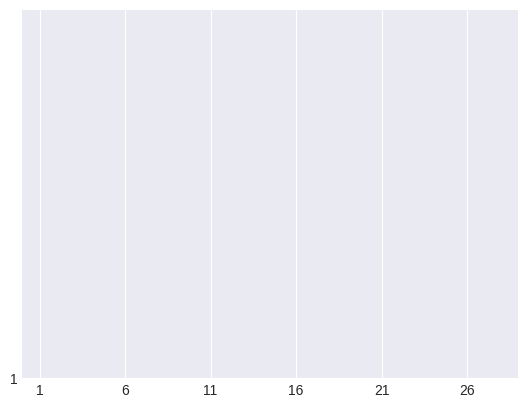

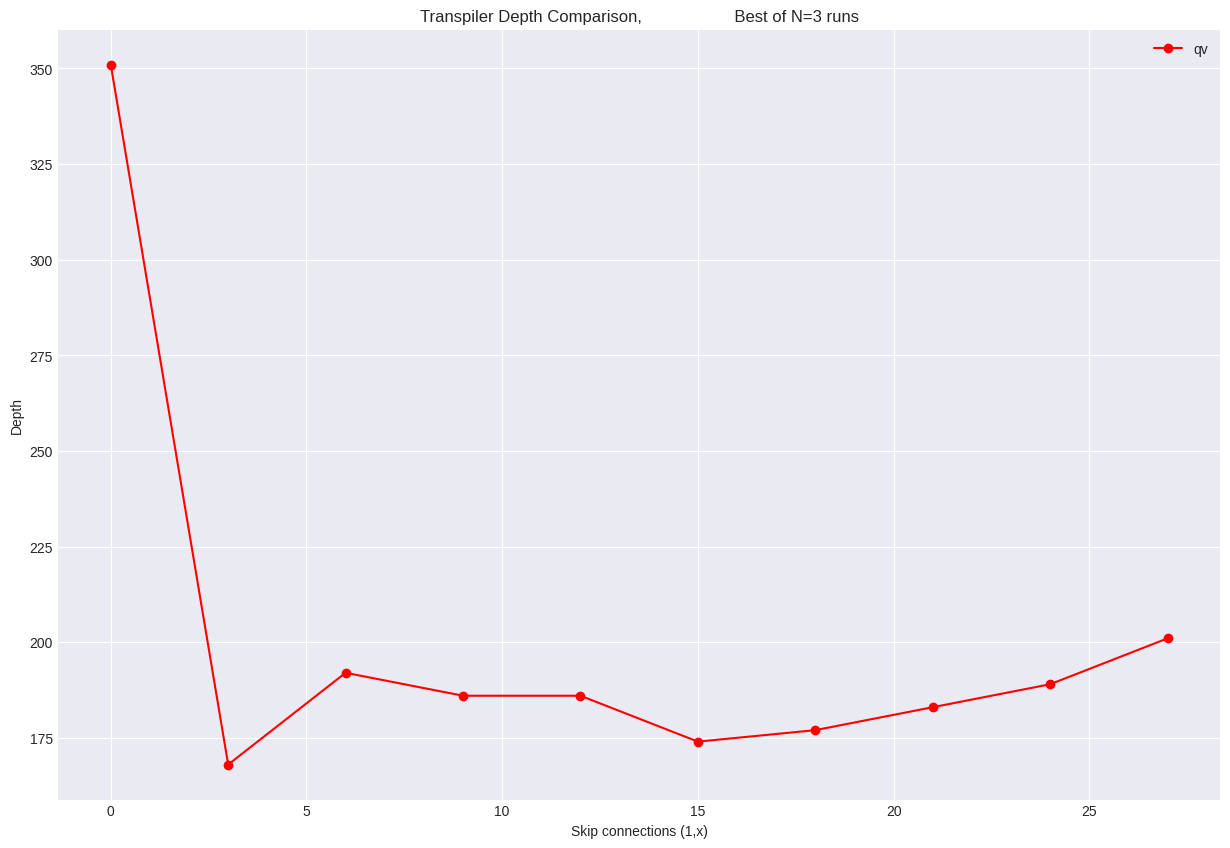

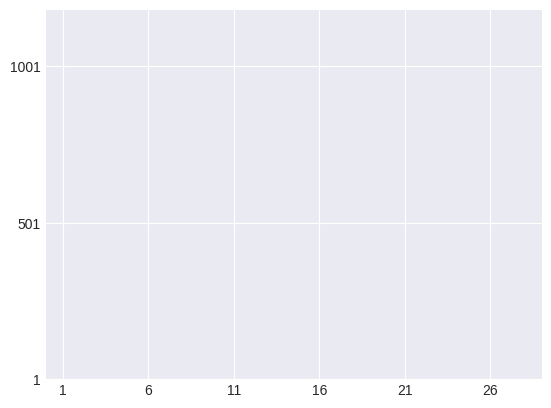

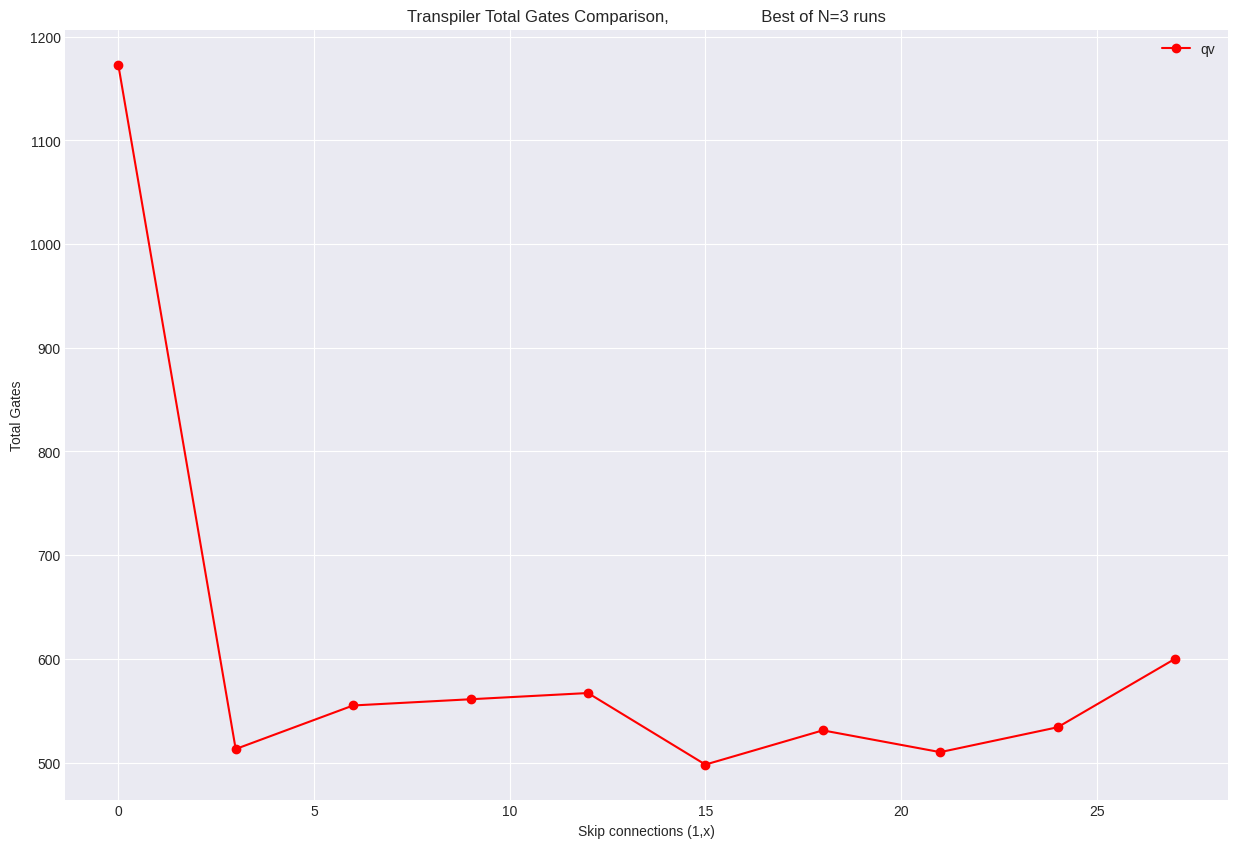

In [255]:
with plt.style.context("seaborn-darkgrid"):
    bar_width = 0.35
    transpiler_count = len(benchmark.transpilers)

    # Define color palette, may need to add more colors in data exceeds current number of colors
    colors = ['#ff0000', '#ff8000', '#ffff00', '#80ff00', '#009900', '#00cccc', 
                '#0000cc', '#b266ff', '#ff66b2', '#606060', "#1f77b4", "#ff7f0e", 
                "#0000cc", "#ffcce5", "#B6196D", "#A800A8", "#5F69F7", "#5FBAF7", 
                "#1EE7EE", "#1EEE78", "#ACF954" ,"#E8F954", "#D1A513", "#FF007f"]


    circuits = ['qv',
                'qft',
                'qaoa_vanilla',
                'tim',
                'adder',
                'GHZ' ]

    # Loop over metrics
    for metric_name, results in benchmark.results.items():
        labels = []
        plotlines = {} #x y info for each corral
        
        fig, ax = plt.subplots()
        qubits = benchmark.submodules[0].rangeQ
        # Create a line for each circuit
        for i, (circuit_name, circuit_results) in enumerate(results.items()):
            # print(f'i: {i}, circ name: {circuit_name}')
            # Create a line for each qubit at different corral connection patterns
            for j, transpiler_result in enumerate(circuit_results):
                # print(f'j: {j}, transpiler res: {transpiler_result}')
                label = circuits[i]
                if label not in labels: #transpiler result is str of corral name
                    labels.append(label) 
                # ax.scatter(qubits[i], circuit_results[transpiler_result], c = colors[j%len(colors)], label = transpiler_result,linewidth=2.0)
                if label in plotlines:
                    plotlines[label][0].append(int(transpiler_result ))
                    plotlines[ label][1].append(circuit_results[transpiler_result] )
                else:
                    plotlines[label] = [[ int(transpiler_result) ], [circuit_results[transpiler_result] ]] 
                    #each line for different qubit, x is corral, y is depth

        max_height = 0
        max_x = 0
        plt.figure(figsize=(15,10))
        for i, c in enumerate(plotlines):
            plt.plot(plotlines[c][0], plotlines[c][1], marker = 'o', color = colors[i])
            if max(plotlines[c][1]) > max_height:
                max_height = max(plotlines[c][1])
            if max(plotlines[c][0]) > max_x:
                max_x = max(plotlines[c][0])

        # Add labels, title, etc
        plt.xlabel("Skip connections (1,x)")
        plt.ylabel(metric_name)
        # subtitle Best of N={self.num_runs} runs
        plt.title(
            f"Transpiler {metric_name} Comparison,\
                    Best of N={benchmark.num_runs} runs"
        )

        max_fontsize = 10
        min_fontsize = 4
        font_size = max(min(max_fontsize, 800 // len(results)), min_fontsize)

        ax.set(xlim=(0, max_x+2), xticks=np.arange(1, max_x+2, 5),
        ylim=(0, max_height+10), yticks=np.arange(1, max_height+10, 500))
        plt.legend(labels) #number of qubits in circuit


        # Show the plot
        plt.show()


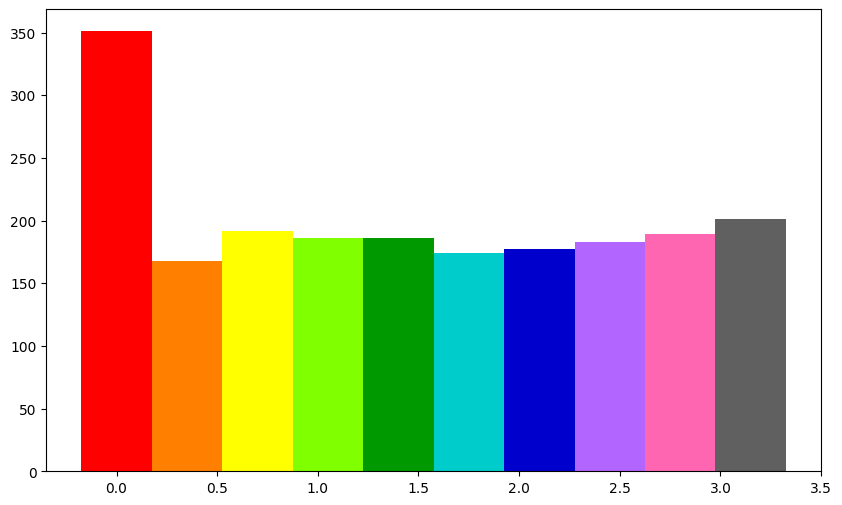

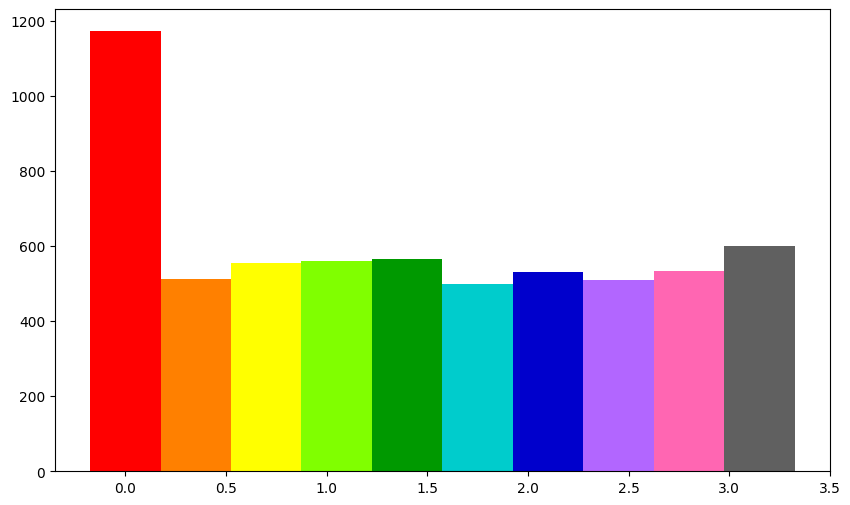

In [256]:
transpiler_count = len(benchmark.transpilers)
# Define color palette, may need to add more colors in data exceeds current number of colors
colors = ['#ff0000', '#ff8000', '#ffff00', '#80ff00', '#009900', '#00cccc', 
                  '#0000cc', '#b266ff', '#ff66b2', '#606060', "#1f77b4", "#ff7f0e", 
                  "#0000cc", "#ffcce5", "#B6196D", "#A800A8", "#5F69F7", "#5FBAF7", 
                  "#1EE7EE", "#1EEE78", "#ACF954" ,"#E8F954", "#D1A513", "#FF007f"]


# Loop over metrics
for metric_name, results in benchmark.results.items():
    # Create figure for each metric
    bar_width = 0.35
    plt.figure(figsize=(10, 6))

    for i, (circuit_name, circuit_results) in enumerate(results.items()):
        circuit_results = list(circuit_results.values())
        # Create a bar for each transpiler
        for j, transpiler_result in enumerate(circuit_results):
            plt.bar(
                i * transpiler_count + j * bar_width,
                transpiler_result,
                width=bar_width,
                color=colors[
                    j % len(colors)
                ],  # choose color based on transpiler index
                label=f"{benchmark.transpilers[j].name}"
                if i == 0
                else "",  # avoid duplicate labels
            )

plt.show()

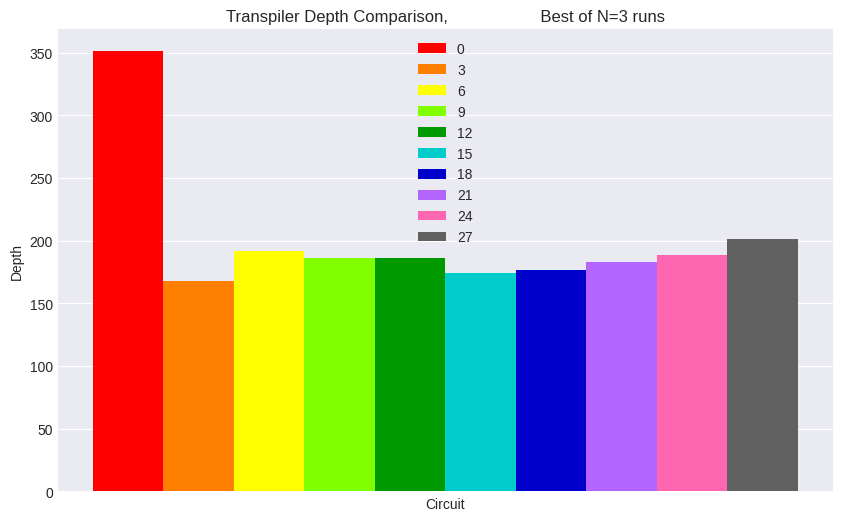

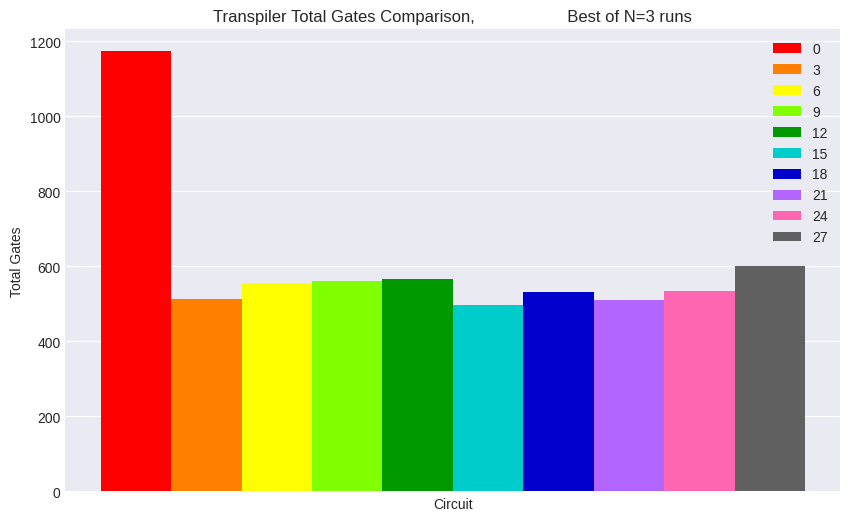

In [257]:
with plt.style.context("seaborn-darkgrid"):
    bar_width = 0.35
    transpiler_count = len(benchmark.transpilers)

    # Define color palette (add more colors if you have more than 2 transpilers)
    colors = ['#ff0000', '#ff8000', '#ffff00', '#80ff00', '#009900', '#00cccc', 
                  '#0000cc', '#b266ff', '#ff66b2', '#606060', "#1f77b4", "#ff7f0e", 
                  "#0000cc", "#ffcce5", "#B6196D", "#A800A8", "#5F69F7", "#5FBAF7", 
                  "#1EE7EE", "#1EEE78", "#ACF954" ,"#E8F954", "#D1A513", "#FF007f"]

    # Loop over metrics
    for metric_name, results in benchmark.results.items():
        # Create figure for each metric
        plt.figure(figsize=(10, 6))

        # Create a bar for each circuit
        for i, (circuit_name, circuit_results) in enumerate(results.items()):
            circuit_results = list(circuit_results.values())
            # Create a bar for each transpiler
            for j, transpiler_result in enumerate(circuit_results):
                plt.bar(
                    i * transpiler_count + j * bar_width,
                    transpiler_result,
                    width=bar_width,
                    color=colors[
                        j % len(colors)
                    ],  # choose color based on transpiler index
                    label=f"{benchmark.transpilers[j].name}"
                    if i == 0
                    else "",  # avoid duplicate labels
                )

        # Add labels, title, etc
        plt.xlabel("Circuit")
        plt.ylabel(metric_name)
        # subtitle Best of N={self.num_runs} runs
        plt.title(
            f"Transpiler {metric_name} Comparison,\
                    Best of N={benchmark.num_runs} runs"
        )

        max_fontsize = 10
        min_fontsize = 4
        font_size = max(min(max_fontsize, 800 // len(results)), min_fontsize)

        # Set x-ticks labels once for each metric
        plt.xticks(
            np.arange(len(results)) * transpiler_count
            + bar_width * (transpiler_count - 1) / 2,
            results.keys(),
            rotation="vertical",
            fontsize=font_size,
        )

        plt.legend()

        # Show the plot
        plt.show()

In [258]:
def plot_bars(b, metric_name, cmap, bar_width):
    """Plot a bar for each circuit and each transpiler."""
    transpiler_count = len(b.transpilers)
    results = b.results.results[metric_name]

    for i, (circuit_name, circuit_results) in enumerate(results.items()):
        for j, transpiler in enumerate(b.transpilers):
            result_metrics = b.results.get_metrics(
                metric_name, circuit_name, transpiler.name
            )

            # Plot the average
            plt.bar(
                i * transpiler_count + j * bar_width,
                result_metrics.average,
                width=bar_width,
                color=cmap(j),
                # yerr=result_metrics.stderr,
                label=f"{transpiler.name}" if i == 0 else "",
            )

            # Mark the best and worst results
            plt.plot(
                [
                    i * transpiler_count + j * bar_width,
                    i * transpiler_count + j * bar_width,
                ],
                [result_metrics.best, result_metrics.worst],
                color="red",
                linewidth=1,
            )

            plt.scatter(
                [
                    i * transpiler_count + j * bar_width,
                    i * transpiler_count + j * bar_width,
                ],
                [result_metrics.best, result_metrics.worst],
                color="red",
                marker=".",
                s=10,
            )

def plotBars(b, save=False):
    """Plot benchmark results."""
    with plt.style.context(["ipynb", "colorsblind10"]):
        bar_width = 0.5
        transpiler_count = len(b.transpilers)
        cmap = plt.cm.get_cmap("tab10", transpiler_count)

        # set legend and axis font size
        plt.rc("legend", fontsize=10)
        plt.rc("axes", labelsize=10)

        for metric_name in b.results.results.keys():
            plt.figure(figsize=(3.5, 2.5))
            b.plot_bars(metric_name, cmap, bar_width)

            plt.xlabel("Circuit")
            plt.ylabel(metric_name)

            max_fontsize = 10
            min_fontsize = 4
            font_size = max(
                min(max_fontsize, 800 // len(b.results.results[metric_name])),
                min_fontsize,
            )

            plt.xticks(
                np.arange(len(b.results.results[metric_name])) * transpiler_count
                + bar_width * (transpiler_count - 1) / 2,
                b.results.results[metric_name].keys(),
                rotation="vertical",
                fontsize=font_size,
            )

            # make the title font size smaller
            plt.title(
                f"Transpiler {metric_name} Comparison\nAverage of N={b.num_runs} runs",
                fontsize=font_size,
            )

            plt.legend()

            if save:
                plt.savefig(f"transpile_benchy_{metric_name}.svg", dpi=300)

            plt.show()

In [259]:
import logging
from transpile_benchy.benchmark import Benchmark

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
transpile_benchy_logger.setLevel(logging.INFO)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)
transpilersCorral = []
for c in input_corrals:
    transpilersCorral.append(corral(input_corrals[c], name =str(c))) #name is number of skipped qubits in connections connection would be (1,c)

benchmark = Benchmark(
    transpilers=transpilersCorral,
    submodules=[qv_bench,
                qft_bench,
                qaoa_vanilla_bench,
                tim_ham_bench,
                adder_bench,
                GHZ_bench ],
    metrics=[depth_metric, total_metric],
    logger = transpile_benchy_logger,
)
benchmark.run()
plot(b = benchmark, save=True)

Running circuits for CircuitBench:   0%|          | 0/1 [00:00<?, ?it/s]

In [191]:

benchmark.results

{'Depth': {'quantum_volume_[8,8,649]': {'0': 66,
   '3': 42,
   '6': 39,
   '9': 51,
   '12': 48,
   '15': 48,
   '18': 48,
   '21': 42,
   '24': 54,
   '27': 42,
   '30': 39,
   '33': 42,
   '36': 54,
   '39': 54,
   '42': 39,
   '45': 57,
   '48': 54,
   '51': 54,
   '54': 51,
   '57': 57,
   '60': 57,
   '63': 48},
  'QFT': {'0': 55,
   '3': 52,
   '6': 60,
   '9': 56,
   '12': 65,
   '15': 51,
   '18': 56,
   '21': 63,
   '24': 59,
   '27': 53,
   '30': 45,
   '33': 55,
   '36': 54,
   '39': 51,
   '42': 56,
   '45': 53,
   '48': 49,
   '51': 51,
   '54': 54,
   '57': 54,
   '60': 56,
   '63': 46},
  'circuit-20975569': {'0': 59,
   '3': 58,
   '6': 54,
   '9': 53,
   '12': 50,
   '15': 47,
   '18': 45,
   '21': 56,
   '24': 50,
   '27': 53,
   '30': 37,
   '33': 47,
   '36': 51,
   '39': 53,
   '42': 49,
   '45': 48,
   '48': 54,
   '51': 53,
   '54': 51,
   '57': 57,
   '60': 48,
   '63': 51},
  'circuit-21002288': {'0': 26,
   '3': 26,
   '6': 26,
   '9': 26,
   '12': 26,
   '15

In [ ]:
# plot(b = benchmark, save=True)

In [ ]:
plotBars(b=benchmark, save=True)